# Proyecto de clase IA-UNSAM

## Clasificación Protón-Hierro

En este proyecto abordaré un problema de clasificación binaria usando datos generados por simulaciones de lluvias de astropartículas. Dichas simulaciones están compuestas por dos partes, la reproducción de la cascada de partículas secundarias producidas por la astropartícula primaria al ingresar al atmósfera terrestre. La segunda parte es la respuesta de los detectores, que en este caso son tres, detectores Cherenkov de agua (SD), detectores de muones puestos a 2 m bajo tierra (MD) y antenas de radio (RD). 

Cada uno de ellos es eficiente en la detección de una de la componentes
de la lluvia, en el caso del MD se encuentra bajo tierra con el fin de aislar la componente
electromagnética de la lluvia (e$^{-}$e$^{+}$, $\gamma$) y captar los muones más energéticos
que se produjeron al iniciar la cascada. Esta característica lo hace especial para buscar
entender la composición química de la partícula primaria. De otra parte el RD tiene como característica principal detectar la componente electromagnética, ya que es transparente a los muones. Es así que usando el RD es posible estimar el X$_{max}$, el cual da información del punto en el cual se generó el numero máximo de partículas secundarias en la lluvia. Este estimador esta relacionado con las sección eficaz de la partícula primaria y a su vez con su composición química de esta.

Sin embargo, ninguno de estos dos detectores es muy eficiente para distinguir entre una señal
proveniente de una astropartícula de aquella que no lo es. Por ello, se usa el SD para *triggerear*
los otros dos detectores, además que este da una muy buena estimación de la energía del primario.
En la imagen de la izquierda se puede ver una ilustración de un detector Cherenkov y bajo de él los
paneles centelladores del MD. Así mismo, a la derecha se puede ver una de las antenas de radio
usadas para detectar las astropartículas, usualmente estas se encuentran cerca de los SD.

Finalmente, las simulaciones se realizaron para lluvias generadas por Protones (P) y núcleos de hierro (Fe) por ser estos los limites liviano y pesado de los primarios. En este trabajo se pretende una primera aproximación por lo que se usaran algunas variables de la lluvia que fueron usadas como *input* de las simulación a las cuales llamaré *True*.

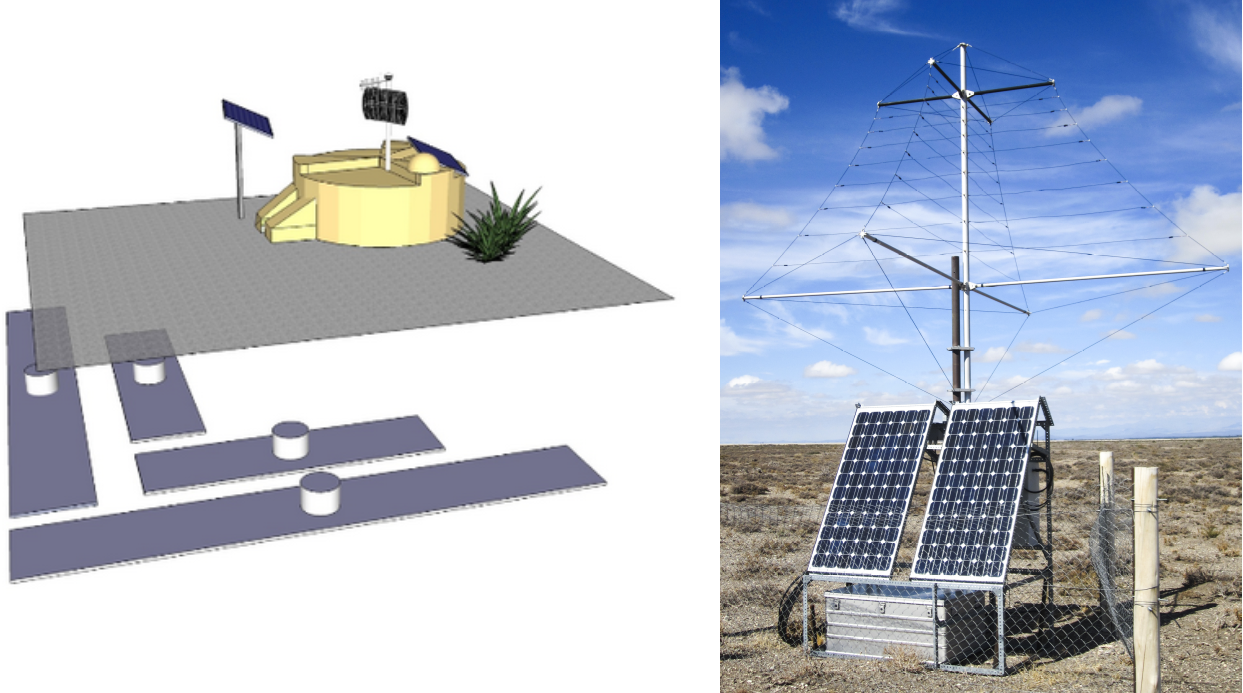

In [1]:
#Librerias importantes
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, balanced_accuracy_score,precision_recall_curve, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

## Acerca de los datos

Estos datos son el resultado de una selección de 10600 eventos simulados, 5300 eventos para P y 5300 para Fe. De estos eventos se extrajeron las siguientes variables o *features*,

* Energía de la partícula primaria (True)
* Ángulo cenital (True)
* Ángulo acimutal (True)
* número de antenas involucradas en el el evento
* Ángulo entre la lluvia y el campo geomagnético, alpha
* Xmax (True)
* Energía radiada, Srad
* Densidad de muones, $\rho_{\mu}$
* target, 1 = Fe, 0 = P

El número de instancias sera de 1028, 514 para cada partícula.

In [2]:
#Cargando datos
df= pd.read_csv(r"/home/csarmiento/MEGA/phd_mega/analisisDeDatos/ML_MassComp/data_PFe_prepared_MC_.txt", delimiter=" ")

In [3]:
print(df.shape)

(1028, 9)


In [4]:
df.head()  #Hierro (Fe)

,energy,zenith,azimuth,antennas,alpha,Xmax,srad,muons,target
0,1.549610e+18,41.0088,303.544,6,89.7990,641.545,17195100.0,2.375530,1
1,7.992670e+17,47.9999,20.302,7,51.1919,660.695,3593490.0,1.531090,1
2,5.768820e+17,52.0915,252.634,8,75.4903,616.069,2960650.0,0.817683,1
3,8.181170e+17,49.0520,227.238,12,85.4818,633.066,5530980.0,1.681410,1
4,5.268060e+17,48.4671,335.087,8,80.7137,607.021,2085010.0,0.904964,1


## Vizualización de los datos

Esta sección tiene el objetivo de analizar gráficamente como se relacionan los *features* entre ellos
y con el tipo de partícula primaria.

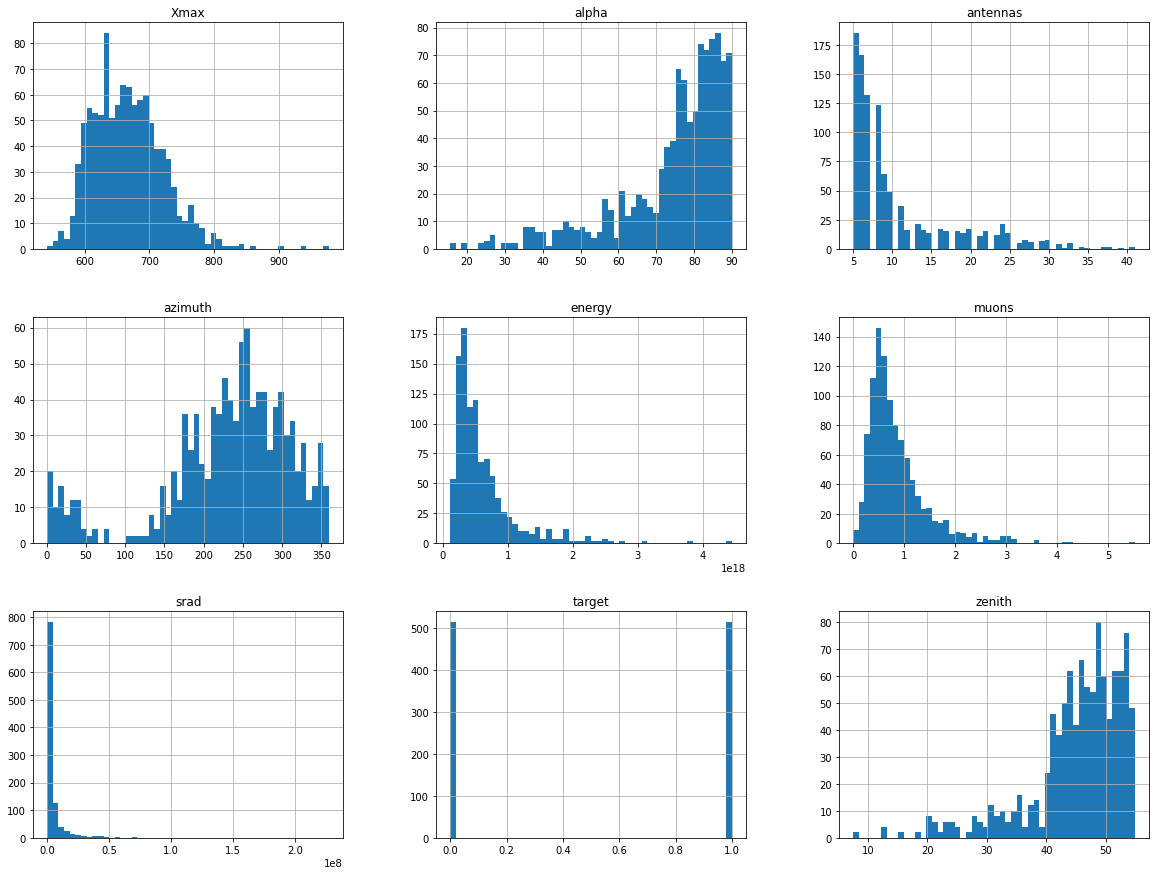

In [5]:
df.hist(bins=50, figsize=(20,15))
plt.show();

En estos histogramas solo el Xmax da la sensación de entrever algún tipo de separación.
Sin embargo, estos histogramas permiten tener un acercamiento a los datos y ver que el ángulo
acimutal sigue la modulación esperada, que la mayoría de los eventos de tiene un ángulo
cenital mayor a 30°, que la distribución del número de antenas es muy asimétrica por lo que
se podría usar para la selección de los eventos de *train* y *test*.

Ahora vamos a explorar los datos con *Seaborn* que permite diferenciarlos por clase.

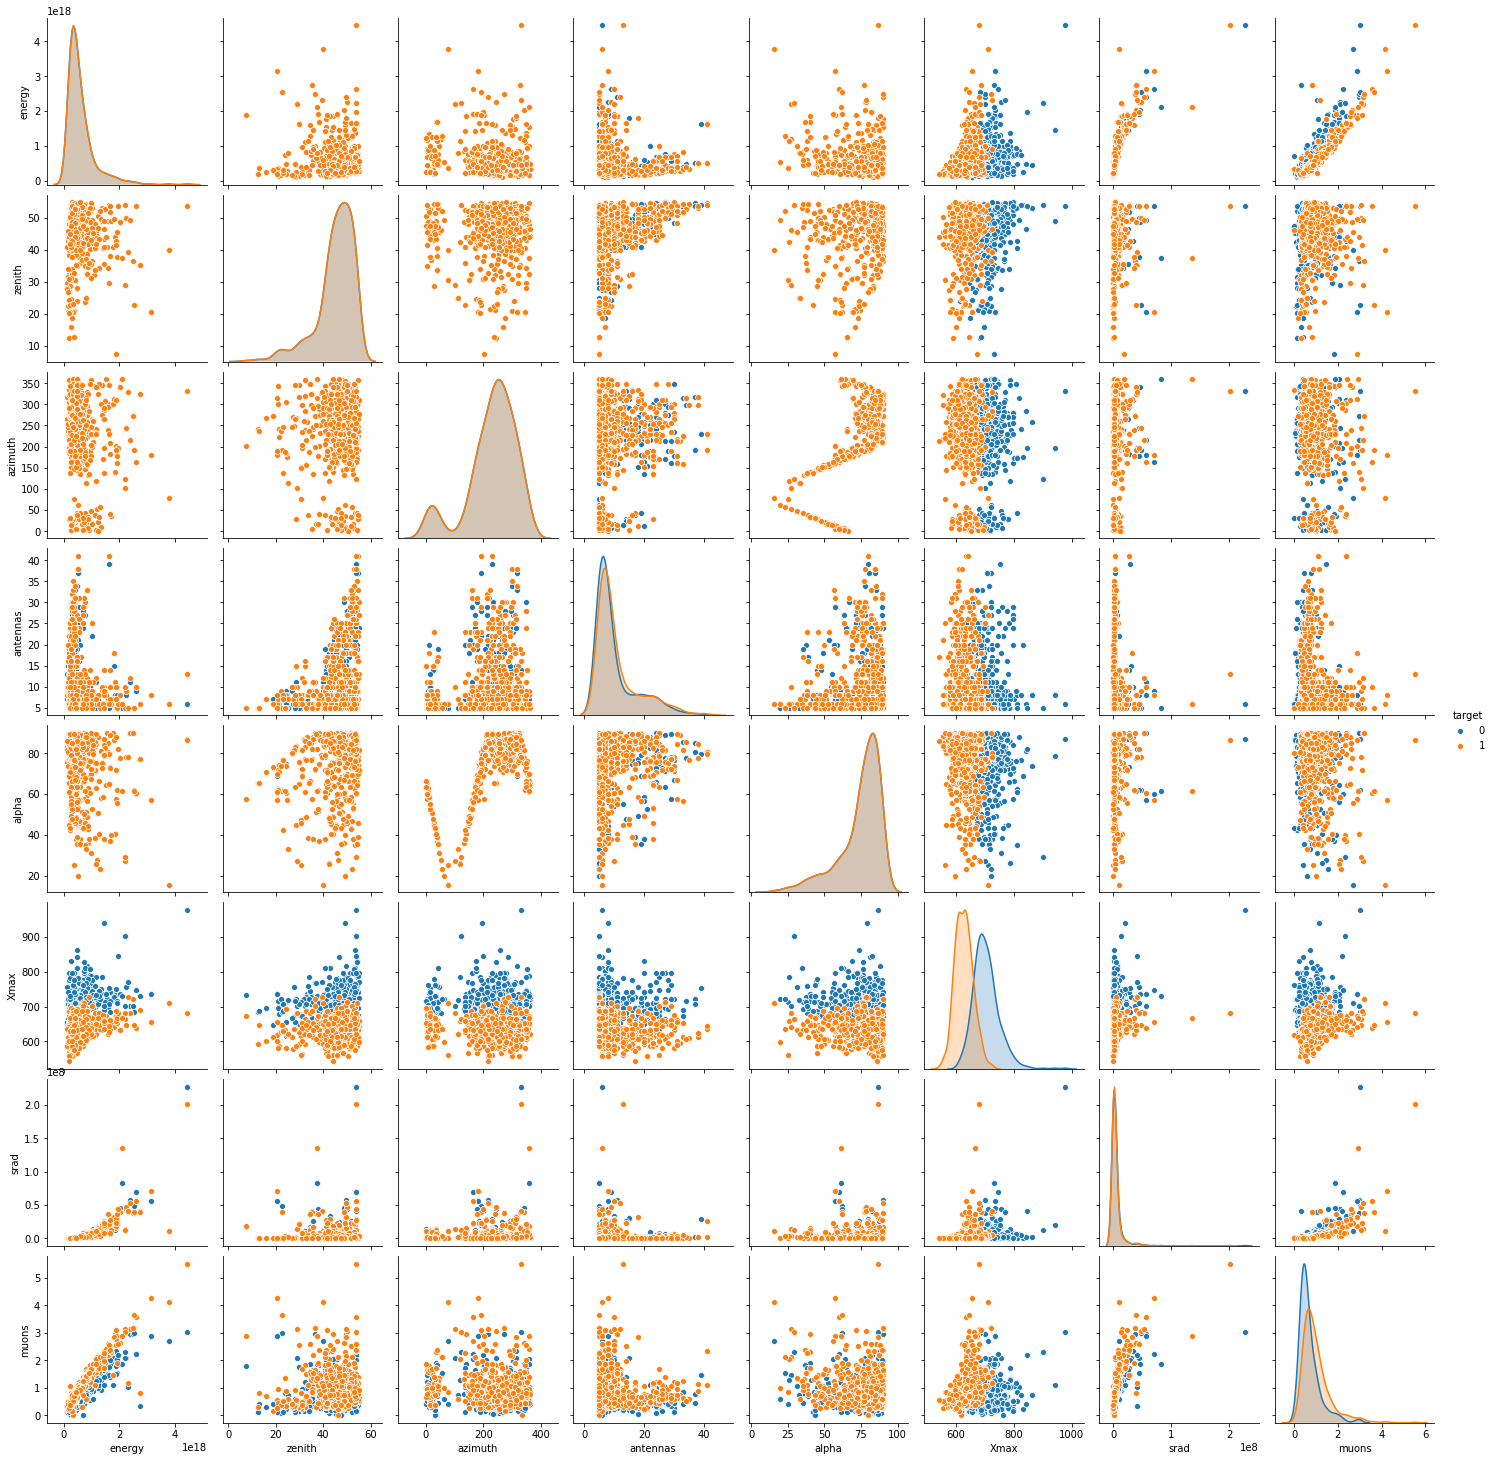

In [6]:
import seaborn as sns

sns.pairplot(df, hue="target");

Ahora esta claro que el Xmax es un *feature* con potencial para clasificar. Además en la distribución de muones se ve una leve separación de las dos clases, más interesante aún es la relación existente entre la muones y la energía y la Srad.

### correlaciones entre los features y el target

Para seguir adentrándonos en los datos vamos a usar el coeficiente de pearson para medir la
correlación lineal entre los *features* y las clases.

In [7]:
corr_matrix = df.corr()
corr_matrix["target"].sort_values(ascending=False)

target      1.000000e+00
muons       2.622240e-01
antennas    5.199726e-02
azimuth     4.660395e-18
zenith      0.000000e+00
energy      0.000000e+00
alpha      -2.418071e-04
srad       -7.282723e-03
Xmax       -7.046666e-01
Name: target, dtype: float64

Aquí podemos ver que como era esperado el X$_{max}$ y $\rho_{\mu}$ son lo que tienen mas correlación.
Ahora, basado en lo anterior se combinaran algunos *features* para ver si se encuentra
algo mejor a lo ya expuesto.

In [8]:
#generamos un set de datos auxiliar para no tocar nuestros datos originales
auxdf_ = df.copy()

In [9]:
auxdf_["muons_Xmax"] = auxdf_["muons"]/auxdf_["Xmax"]
auxdf_["muons_Ener"] = auxdf_["muons"]/auxdf_["energy"]
auxdf_["muons_srad"] = auxdf_["muons"]/auxdf_["srad"]
auxdf_["muons_root-srad"] = auxdf_["muons"]/np.sqrt(auxdf_["srad"])
auxdf_["Xmax_srad"] = auxdf_["Xmax"]/auxdf_["srad"]
auxdf_["Xmax_root-srad"] = auxdf_["Xmax"]/np.sqrt(auxdf_["srad"])
auxdf_["Xmax_Ener"] = auxdf_["Xmax"]/auxdf_["energy"]

In [10]:
corr_matrix = auxdf_.corr()
corr_matrix["target"].sort_values(ascending=False)

target             1.000000e+00
muons_Ener         6.096288e-01
muons_root-srad    5.682659e-01
muons_Xmax         3.414565e-01
muons_srad         2.694742e-01
muons              2.622240e-01
antennas           5.199726e-02
azimuth            4.660395e-18
zenith             0.000000e+00
energy             0.000000e+00
alpha             -2.418071e-04
Xmax_srad         -7.007002e-03
srad              -7.282723e-03
Xmax_root-srad    -5.261923e-02
Xmax_Ener         -9.936786e-02
Xmax              -7.046666e-01
Name: target, dtype: float64

Como se puede ver las combinaciones $\rho_{\mu}/E$, $\rho_{\mu}/\sqrt{Srad}$, $\rho_{\mu}/Srad$ y $\rho_{\mu}/X_{max}$ aumentaron fuertemente la correlación con las clases. Por otro lado, las mismas combinaciones con el X$_{max}$ no surtieron el mismo efecto. Esto se debe a que el X$_{max}$ no tiene una fuerte dependencia con la energía, como se pudo ver en los histogramas anteriores.

A continuación, se puede ver como se relacionan estos nuevos *features* con el X$_{max}$.

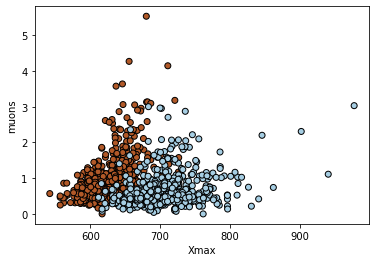

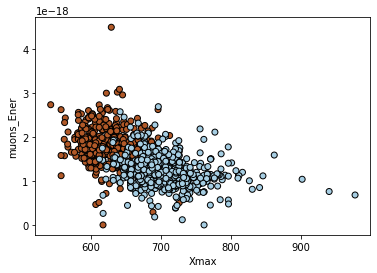

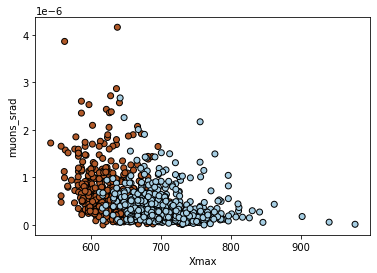

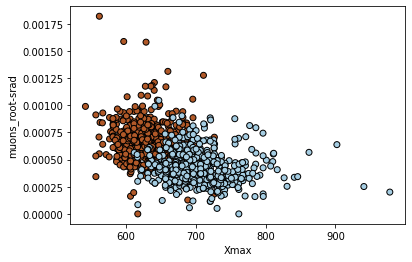

In [11]:
feature_names=["energy", "zenith", "azimuth", "antennas", "alpha", "Xmax", "srad", "muons",
               "muons_Ener", "muons_srad", "muons_root-srad", "target"]

# Plot also the training points
for pair in (["Xmax", "muons"], ["Xmax", "muons_Ener"], ["Xmax", "muons_srad"], ["Xmax", "muons_root-srad"]):
  plt.scatter(auxdf_[pair[0]], auxdf_[pair[1]], c=auxdf_["target"], edgecolors='k', cmap=plt.cm.Paired)
  plt.xlabel(pair[0])
  plt.ylabel(pair[1])
  plt.show()

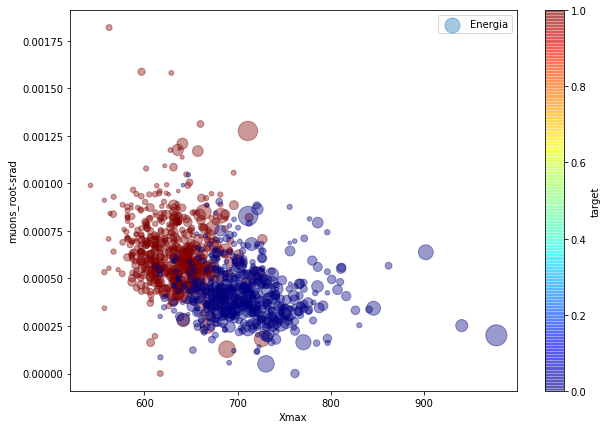

In [12]:
auxdf_.plot(kind="scatter", x="Xmax", y="muons_root-srad", alpha=0.4,
    s=auxdf_["energy"]/1e16, label="Energia", figsize=(10,7),
    c="target",cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

Como resultado de este pre-análisis vamos a agregar tres nuevos *features*,
$$\frac{\rho_{\mu}}{E}$$,
$$\frac{\rho_{\mu}}{\sqrt{Srad}}$$,
$$\frac{\rho_{\mu}}{X_{max}}$$

In [13]:
new_df = df.copy() 

new_df["muons_Xmax"] = new_df["muons"]/new_df["Xmax"]
new_df["muons_Ener"] = new_df["muons"]/new_df["energy"]
new_df["muons_root_srad"] = new_df["muons"]/np.sqrt(new_df["srad"])

## Preparación de los datos

Con la idea de hacer un análisis más intensivo se crearan 3 conjuntos de datos así.

* Datos originales.
* Datos aumentados con los nuevos features.
* Datos con los 5 features que mejor correlación tienen con el target.

### Separación de datos en train y test

Se usará una selección estratificada basada en el número de antenas involucradas en los eventos.
Así, se evita tener conjuntos de datos descompensados y que no representen bien la generalidad de los mismos.

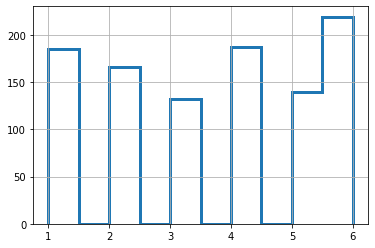

In [14]:
new_df["antennas_cut"] = pd.cut(new_df["antennas"],
                               bins=[4., 5., 6, 7, 9, 14, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])

new_df["antennas_cut"].hist(histtype='step',linewidth=3, label="Antenas")

In [15]:
new_df["antennas_cut"].value_counts()

6    219
4    187
1    185
2    166
5    139
3    132
Name: antennas_cut, dtype: int64

In [16]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(new_df, new_df["antennas_cut"]):
    train_set = new_df.loc[train_index]
    test_set = new_df.loc[test_index]
    
train_set=train_set.drop(["antennas_cut"], axis=1)
test_set=test_set.drop(["antennas_cut"], axis=1)
print(train_set.shape, test_set.shape)

(822, 12) (206, 12)


In [17]:
df_train = train_set.copy()
df_test = test_set.copy()

# eliminamos el target que se usa para clasificar
df_train = df_train.drop("target", axis=1) 
df_train_labels = train_set["target"].copy()

df_test = df_test.drop("target", axis=1) 
df_test_labels = test_set["target"].copy()

print(df_train.shape, df_train_labels.shape, df_test.shape, df_test_labels.shape)

(822, 11) (822,) (206, 11) (206,)


### Pre-procesamiento

#### set de datos 1 -> todos los features

In [18]:
"""
Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media 
y dividimos por su desviación estándard. Esto es típico y ayuda a la 
convergencia de los algoritmos.
"""

from sklearn.preprocessing import StandardScaler

df_train_ = df_train.drop(["muons_Xmax", "muons_Ener", "muons_root_srad"], axis=1)
df_test_ = df_test.drop(["muons_Xmax", "muons_Ener", "muons_root_srad"], axis=1)

scaler = StandardScaler()
h_train = scaler.fit_transform(df_train_)
h_test = scaler.fit_transform(df_test_)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train = pd.DataFrame(h_train, columns=df_train_.columns)
df_prep_test = pd.DataFrame(h_test, columns=df_test_.columns)


In [19]:
X_train=df_prep_train
y_train=df_train_labels

X_test=df_prep_test
y_test=df_test_labels

In [20]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(822, 8) (206, 8) (822,) (206,)


In [21]:
X_train.head()

,energy,zenith,azimuth,antennas,alpha,Xmax,srad,muons
0,-0.273900,-0.256748,-2.426921,0.620539,-1.977896,-1.146387,-0.292109,-0.074327
1,-0.187167,-0.121186,-0.162992,-0.514871,0.808537,0.142741,-0.180511,-0.380341
2,-0.712046,-0.021339,0.184168,-0.798724,0.653375,-0.091508,-0.331239,-0.929132
3,-0.323929,-0.857803,0.018752,-0.798724,0.840217,0.516506,-0.250702,-0.530143
4,-0.119968,-0.488233,-0.467239,-0.656797,-0.196418,0.309158,-0.142668,-0.281717


#### set de datos 2 -> todos los features más tres nuevos

In [22]:
scaler = StandardScaler()
h_train_2 = scaler.fit_transform(df_train)
h_test_2 = scaler.fit_transform(df_test)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train_2 = pd.DataFrame(h_train_2, columns=df_train.columns)
df_prep_test_2 = pd.DataFrame(h_test_2, columns=df_train.columns)


In [23]:
X_train_2=df_prep_train_2
y_train_2=df_train_labels

X_test_2=df_prep_test_2
y_test_2=df_test_labels

In [24]:
print(X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape)

(822, 11) (206, 11) (822,) (206,)


In [25]:
X_train_2.head()

,energy,zenith,azimuth,antennas,alpha,Xmax,srad,muons,muons_Xmax,muons_Ener,muons_root_srad
0,-0.273900,-0.256748,-2.426921,0.620539,-1.977896,-1.146387,-0.292109,-0.074327,0.058827,0.391978,1.040428
1,-0.187167,-0.121186,-0.162992,-0.514871,0.808537,0.142741,-0.180511,-0.380341,-0.400758,-0.647473,-0.798749
2,-0.712046,-0.021339,0.184168,-0.798724,0.653375,-0.091508,-0.331239,-0.929132,-0.941050,-0.697611,-0.794682
3,-0.323929,-0.857803,0.018752,-0.798724,0.840217,0.516506,-0.250702,-0.530143,-0.576093,-0.673583,-0.667908
4,-0.119968,-0.488233,-0.467239,-0.656797,-0.196418,0.309158,-0.142668,-0.281717,-0.316803,-0.580841,-0.794972


#### set de datos 3 -> mejores feaures

En este paso usé *SelectKBest* con la opción *f_classif* que selecciona los *features* que tienen 
mayor correlación lineal entre ellos. Como se puede ver esta elección es acorde con el análisis previamente realizado.

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif

X_5_best= SelectKBest(f_classif, k=5).fit(X_train_2, y_train_2)

mask = X_5_best.get_support() #list of booleans for selected features
new_feat = []

for bool, feature in zip(mask, X_train_2.columns):
    if bool:
        new_feat.append(feature)

print("he best features are:{}".format(new_feat)) # The list of your 5 best features

he best features are:['Xmax', 'muons', 'muons_Xmax', 'muons_Ener', 'muons_root_srad']


In [27]:
df_train=df_train[['Xmax', 'muons', 'muons_Xmax', 'muons_Ener', 'muons_root_srad']]
df_test=df_test[['Xmax', 'muons', 'muons_Xmax', 'muons_Ener', 'muons_root_srad']]

In [28]:
print(df_train.shape, df_test.shape)

(822, 5) (206, 5)


In [29]:
scaler = StandardScaler()
h_train_3 = scaler.fit_transform(df_train)
h_test_3 = scaler.fit_transform(df_test)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
df_prep_train_3 = pd.DataFrame(h_train_3, columns=df_train.columns)
df_prep_test_3 = pd.DataFrame(h_test_3, columns=df_train.columns)

In [30]:
X_train_3=df_prep_train_3
y_train_3=df_train_labels

X_test_3=df_prep_test_3
y_test_3=df_test_labels

In [31]:
print(X_train_3.shape, X_test_3.shape, y_train_3.shape, y_test_3.shape)

(822, 5) (206, 5) (822,) (206,)


In [32]:
X_train_3.head()

,Xmax,muons,muons_Xmax,muons_Ener,muons_root_srad
0,-1.146387,-0.074327,0.058827,0.391978,1.040428
1,0.142741,-0.380341,-0.400758,-0.647473,-0.798749
2,-0.091508,-0.929132,-0.941050,-0.697611,-0.794682
3,0.516506,-0.530143,-0.576093,-0.673583,-0.667908
4,0.309158,-0.281717,-0.316803,-0.580841,-0.794972


## Funciones utiles para evaluar performance

Para evaluar el *perfomance* o rendimiento de nuestros modelos de clasificación se usara inicialmente tres elementos,

* Accuracy 
* Accuracy via cross-validation para verificar si hay sobreajuste 
* Matriz de confusión para tener otros estimadores de la validación como la precisión y exhaustividad. 


In [33]:
#Función para calcular el accuracy
def accuracy(X, y, model):
    a=accuracy_score(y, model.predict(X))
    return a

In [34]:
#Función para calcular el accuracy via Cross-Val score
#Esto nos sirve para validar nuestro modelo sin usar los datos de test
def crossAccuracy(X, y, model):
    scoresGauTrain= cross_val_score(model, X, y, cv=10, scoring="accuracy");
    return scoresGauTrain.mean(), scoresGauTrain.std()

In [35]:
"""
Matriz de Confusion
Con MC podemos ver en detalle el comportamiento del modelo y saber cuantos eventos fueron mal clasificados.
Esta podría ser una mirada más realista que el accuracy.

>>> La precisión es definida como el ratio entre verdaderos positivos y número total 
de positivos predichos. Esto nos dice la fracción de los eventos que el modelo nos 
dice que son de la clase, realmente lo son.

>>> El recall o exhaustividad es definida como el es el ratio entre los verdaderos positivos 
y la suma de los verdaderos positivos y los falsos negativos. Esto nos dice la fracción
de los elementos de la clase encontró.
"""

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
def mconfusion(X, y, model):
    aux_pred = cross_val_predict(model, X, y, cv=5)
    cm = confusion_matrix(y, aux_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    fn = cm[1, 0]
    pres=tp/(tp + fp)
    exha=tp/(tp + fn)
    print("Matriz de confusión, \n"), print(cm), print("precisión: ", pres), print("exhaustividad: ", exha)

## Probando modelos

Con el fin de hallar el modelo que mejor mejor se ajusta a los datos se probará inicialmente con los
tres conjuntos de datos. Luego se elegira los que mejor rendimiento tienen y serán optimizados en una segunda fase. En la primera fase se usaran, regresión logística, SVC (kernel gaussiano), SVC (kernel polinomial) y arboles de decisión.

In [36]:
import sklearn.preprocessing as pp
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

### Regresión logística (fase I)

In [37]:
#Regresión logística datos originales

logi_reg = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("logi_clf", LogisticRegression(class_weight="balanced", random_state=42, n_jobs=-1))
    ])

model_logi=logi_reg.fit(X_train, y_train)

In [38]:
#Regresión logística datos aumentados

logi_reg_2 = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("logi_clf", LogisticRegression(class_weight="balanced", random_state=42, n_jobs=-1))
    ])

model_logi_2=logi_reg_2.fit(X_train_2, y_train_2)

In [39]:
#Regresión logística mejores features

logi_reg_3 = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("logi_clf", LogisticRegression(class_weight="balanced", random_state=42, n_jobs=-1))
    ])

model_logi_3=logi_reg_3.fit(X_train_3, y_train_3)

In [40]:
print("# Reg Log original")
print(accuracy(X_train, y_train, model_logi))
print(crossAccuracy(X_train, y_train, model_logi), "\n")

#
print("# Reg Log aumentada")
print(accuracy(X_train_2, y_train_2, model_logi_2))
print(crossAccuracy(X_train_2, y_train_2, model_logi_2), "\n")

#
print("# Reg Log mejores features")
print(accuracy(X_train_3, y_train_3, model_logi_3))
print(crossAccuracy(X_train_3, y_train_3, model_logi_3), "\n")


# Reg Log original
0.9209245742092458
(0.9110931531002056, 0.04021430187216445) 

# Reg Log aumentada
0.9282238442822385
(0.9184102262709374, 0.03458614592502865) 

# Reg Log mejores features
0.9257907542579076
(0.9233029679694387, 0.025693036505385874) 



### SVC - Kernel gaussiano (Fase I)

In [41]:
from sklearn import svm

In [42]:
#SVC datos originales

gaussian_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(class_weight="balanced", kernel='rbf', random_state=42))
    ])

model_svc_g=gaussian_svm_clf.fit(X_train, y_train)

In [43]:
#SVC datos aumentados

gaussian_svm_clf_2 = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(class_weight="balanced", kernel='rbf', random_state=42))
    ])

model_svc_g_2=gaussian_svm_clf_2.fit(X_train_2, y_train_2)

In [44]:
#SVC datos con mejores features

gaussian_svm_clf_3 = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(class_weight="balanced", kernel='rbf', random_state=42))
    ])

model_svc_g_3=gaussian_svm_clf_3.fit(X_train_3, y_train_3)

In [45]:
print("# SVC gaussiano original")
print(accuracy(X_train, y_train, model_svc_g))
print(crossAccuracy(X_train, y_train, model_svc_g), "\n")

#
print("# SVC gaussiano aumentada")
print(accuracy(X_train_2, y_train_2, model_svc_g_2))
print(crossAccuracy(X_train_2, y_train_2, model_svc_g_2), "\n")

#
print("# SVC gaussiano mejores features")
print(accuracy(X_train_3, y_train_3, model_svc_g_3))
print(crossAccuracy(X_train_3, y_train_3, model_svc_g_2), "\n")

# SVC gaussiano original
0.9330900243309003
(0.9025859535703791, 0.030543533925648934) 

# SVC gaussiano aumentada
0.948905109489051
(0.9233617396414926, 0.01637745696098044) 

# SVC gaussiano mejores features
0.9367396593673966
(0.9269615045548047, 0.029927093602878603) 



### SVC - Kernel polinomial (Fase I)

Luego de probar con varios grados del polinomio, se halló que el grado 3 tenia mejor performance.

In [46]:
#SVC datos originales

poly_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(class_weight="balanced", kernel='poly', degree=3, random_state=42))
    ])

model_svc_p=poly_svm_clf.fit(X_train, y_train)

In [47]:
#SVC datos aumentados

poly_svm_clf_2 = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(class_weight="balanced", kernel='poly', degree=3, random_state=42))
    ])

model_svc_p_2=poly_svm_clf_2.fit(X_train_2, y_train_2)

In [48]:
#SVC mejores features

poly_svm_clf_3 = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(class_weight="balanced", kernel='poly', degree=3, random_state=42))
    ])

model_svc_p_3=poly_svm_clf_3.fit(X_train_3, y_train_3)

In [49]:
print("# SVC polinomial original")
print(accuracy(X_train, y_train, model_svc_p))
print(crossAccuracy(X_train, y_train, model_svc_p), "\n")

#
print("# SVC polinomial aumentada")
print(accuracy(X_train_2, y_train_2, model_svc_p_2))
print(crossAccuracy(X_train_2, y_train_2, model_svc_p_2), "\n")

#
print("# SVC polinomial mejores features")
print(accuracy(X_train_3, y_train_3, model_svc_p_3))
print(crossAccuracy(X_train_3, y_train_3, model_svc_p_2), "\n")

# SVC polinomial original
0.9136253041362531
(0.8928445489274169, 0.03787753617258292) 

# SVC polinomial aumentada
0.940389294403893
(0.9208492506611814, 0.023438041312964546) 

# SVC polinomial mejores features
0.9148418491484185
(0.9098883338230971, 0.028605722793720978) 



### Arboles de decisión (Fase I)

In [50]:
from sklearn.tree import DecisionTreeClassifier

#Arboles de decisión datos originales

dtrees = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("dt_clf", DecisionTreeClassifier(class_weight="balanced", max_depth=5))
    ])

model_dt=dtrees.fit(X_train, y_train)

In [51]:
#Arboles de decisión datos aumentados

dtrees_2 = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("dt_clf", DecisionTreeClassifier(class_weight="balanced", max_depth=5))
    ])

model_dt_2=dtrees_2.fit(X_train_2, y_train_2)

In [52]:
#Arboles de decisión mejores features

dtrees_3 = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("dt_clf", DecisionTreeClassifier(class_weight="balanced", max_depth=5))
    ])

model_dt_3=dtrees_3.fit(X_train_3, y_train_3)

In [53]:
print("# Arboles de decisión original")
print(accuracy(X_train, y_train, dtrees))
print(crossAccuracy(X_train, y_train, dtrees), "\n")

#
print("# Arboles de decisión aumentada")
print(accuracy(X_train_2, y_train_2, dtrees_2))
print(crossAccuracy(X_train_2, y_train_2, dtrees_2), "\n")

#
print("# Arboles de decisión mejores features")
print(accuracy(X_train_3, y_train_3, dtrees_3))
print(crossAccuracy(X_train_3, y_train_3, dtrees_2), "\n")

# Arboles de decisión original
0.9525547445255474
(0.8953276520717015, 0.03154348788055136) 

# Arboles de decisión aumentada
0.9671532846715328
(0.9014105201292978, 0.028155480256595398) 

# Arboles de decisión mejores features
0.9586374695863747
(0.9038789303555687, 0.026981238689329393) 



## Optimización de los modelos

Como resultado del análisis anterior se optimizarán los modelos con los datos aumentados y los
que usan los mejores *features*.

### Regresión logísitica

#### Reg Log con datos aumentada

In [54]:
logi_reg_2 = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("logi_clf", LogisticRegression(class_weight="balanced", random_state=42, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(1, 100), "logi_clf__max_iter": reciprocal(10, 500),
                      "logi_clf__tol": reciprocal(1e-5, 1e-3)}
rnd_search_cv = RandomizedSearchCV(logi_reg_2, param_distributions, n_iter=100, cv=5)

#Fit
rnd_search_cv.fit(X_train_2, y_train_2)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('logi_clf',
                                              LogisticRegression(class_weight='balanced',
                                                                 n_jobs=-1,
                                                                 random_state=42))]),
                   n_iter=100,
                   param_distributions={'logi_clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec0b0b5ad0>,
                                        'logi_clf__max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec0b21d510>,
                                        'logi_clf__tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec0b0b5350>})

In [55]:
model_Log_2 = rnd_search_cv.best_estimator_
model_Log_2

Pipeline(steps=[('scaler', StandardScaler()),
                ('logi_clf',
                 LogisticRegression(C=56.67561145640817,
                                    class_weight='balanced',
                                    max_iter=87.99356917006722, n_jobs=-1,
                                    random_state=42,
                                    tol=0.0005934831738061627))])

In [56]:
print(accuracy(X_train_2, y_train_2, model_Log_2))
print(crossAccuracy(X_train_2, y_train_2, model_Log_2))

0.9306569343065694
(0.9232588892153981, 0.03417492189569225)


In [57]:
mconfusion(X_train_2, y_train_2, model_Log_2)

Matriz de confusión, 

[[393  31]
 [ 31 367]]
precisión:  0.9221105527638191
exhaustividad:  0.9221105527638191


#### Reg Log con mejores features

In [58]:
logi_reg_3 = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("logi_clf", LogisticRegression(class_weight="balanced", random_state=42, n_jobs=-1))
    ])

param_distributions = {"logi_clf__C": uniform(1, 100), "logi_clf__max_iter": reciprocal(10, 500),
                      "logi_clf__tol": reciprocal(1e-5, 1e-3)}
rnd_search_cv = RandomizedSearchCV(logi_reg_3, param_distributions, n_iter=100, cv=5)

#Fit
rnd_search_cv.fit(X_train_3, y_train_3)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('logi_clf',
                                              LogisticRegression(class_weight='balanced',
                                                                 n_jobs=-1,
                                                                 random_state=42))]),
                   n_iter=100,
                   param_distributions={'logi_clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec0acff9d0>,
                                        'logi_clf__max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec09f758d0>,
                                        'logi_clf__tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec05afbd50>})

In [59]:
model_Log_3 = rnd_search_cv.best_estimator_
model_Log_3

Pipeline(steps=[('scaler', StandardScaler()),
                ('logi_clf',
                 LogisticRegression(C=77.68210864558296,
                                    class_weight='balanced',
                                    max_iter=17.754671700182108, n_jobs=-1,
                                    random_state=42,
                                    tol=8.690983849654291e-05))])

In [60]:
print(accuracy(X_train_3, y_train_3, model_Log_3))
print(crossAccuracy(X_train_3, y_train_3, model_Log_3))

0.927007299270073
(0.9245077872465473, 0.029364655899285712)


In [61]:
mconfusion(X_train_3, y_train_3, model_Log_3)

Matriz de confusión, 

[[389  35]
 [ 26 372]]
precisión:  0.914004914004914
exhaustividad:  0.9346733668341709


#### SVC gaussiano, datos aumentados

In [62]:
gaussian_svm_clf_2 = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(class_weight="balanced", probability=True, kernel='rbf', random_state=42))
    ])

param_distributions = {"svm_clf__C": uniform(1, 10), 
                       "svm_clf__tol": reciprocal(1e-6, 1e-4), "svm_clf__gamma": reciprocal(1e-3, 0.1)}
rnd_search_cv = RandomizedSearchCV(gaussian_svm_clf_2, param_distributions, n_iter=100, 
                                   cv=5, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train_2, y_train_2)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svm_clf',
                                              SVC(class_weight='balanced',
                                                  probability=True,
                                                  random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'svm_clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec0ad9df50>,
                                        'svm_clf__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec068e0d50>,
                                        'svm_clf__tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec068e0410>})

In [63]:
model_SVC_g_2 = rnd_search_cv.best_estimator_
model_SVC_g_2

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf',
                 SVC(C=1.44926389968727, class_weight='balanced',
                     gamma=0.03740842069014202, probability=True,
                     random_state=42, tol=2.9302805772907787e-06))])

In [64]:
print(accuracy(X_train_2, y_train_2, model_SVC_g_2))
print(crossAccuracy(X_train_2, y_train_2, model_SVC_g_2))

0.9416058394160584
(0.9318983250073464, 0.013423450218798363)


In [65]:
mconfusion(X_train_2, y_train_2, model_SVC_g_2)

Matriz de confusión, 

[[392  32]
 [ 28 370]]
precisión:  0.9203980099502488
exhaustividad:  0.9296482412060302


#### SVC gaussiano, mejores features

In [66]:
gaussian_svm_clf_3 = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(class_weight="balanced", probability=True, kernel='rbf', random_state=42))
    ])

param_distributions = {"svm_clf__C": uniform(1, 10), 
                       "svm_clf__tol": reciprocal(1e-6, 1e-4), "svm_clf__gamma": reciprocal(1e-3, 0.1)}
rnd_search_cv = RandomizedSearchCV(gaussian_svm_clf_3, param_distributions, n_iter=100, 
                                   cv=5, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train_3, y_train_3)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svm_clf',
                                              SVC(class_weight='balanced',
                                                  probability=True,
                                                  random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'svm_clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec0b112ed0>,
                                        'svm_clf__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec06474e90>,
                                        'svm_clf__tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec09ccddd0>})

In [67]:
model_SVC_g_3 = rnd_search_cv.best_estimator_
model_SVC_g_3

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf',
                 SVC(C=9.420794675543716, class_weight='balanced',
                     gamma=0.03310240360787783, probability=True,
                     random_state=42, tol=2.8039632420737525e-06))])

In [68]:
print(accuracy(X_train_3, y_train_3, model_SVC_g_3))
print(crossAccuracy(X_train_3, y_train_3, model_SVC_g_3))

0.9416058394160584
(0.9294005289450485, 0.025544241184585054)


In [69]:
mconfusion(X_train_3, y_train_3, model_SVC_g_3)

Matriz de confusión, 

[[394  30]
 [ 22 376]]
precisión:  0.9261083743842364
exhaustividad:  0.9447236180904522


#### SVC polinomial, features aumentados

In [70]:
poly_svm_clf_2 = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(class_weight="balanced", probability=True, kernel='poly', degree=3, random_state=42))
    ])
param_distributions = {"svm_clf__C": uniform(1, 10), "svm_clf__coef0":uniform(0, 10), 
                       "svm_clf__tol": reciprocal(1e-5, 1e-3), "svm_clf__gamma": reciprocal(1e-4, 1e-1)}
rnd_search_cv = RandomizedSearchCV(poly_svm_clf_2, param_distributions, n_iter=100, 
                                   cv=5, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train_2, y_train_2)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svm_clf',
                                              SVC(class_weight='balanced',
                                                  kernel='poly',
                                                  probability=True,
                                                  random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'svm_clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec0b1a3b90>,
                                        'svm_clf__coef0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec0adc9cd0>,
                                        'svm_clf__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec09effd50>,
                                        'svm_clf__tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec0b0c1d50>})

In [71]:
model_SVC_p_2 = rnd_search_cv.best_estimator_
model_SVC_p_2

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf',
                 SVC(C=3.8083503941191945, class_weight='balanced',
                     coef0=8.093571986745701, gamma=0.005342395943497952,
                     kernel='poly', probability=True, random_state=42,
                     tol=1.757258270287465e-05))])

In [72]:
print(accuracy(X_train_2, y_train_2, model_SVC_p_2))
print(crossAccuracy(X_train_2, y_train_2, model_SVC_p_2))

0.9452554744525548
(0.9293858360270351, 0.027795972049539923)


In [73]:
mconfusion(X_train_2, y_train_2, model_SVC_p_2)

Matriz de confusión, 

[[397  27]
 [ 30 368]]
precisión:  0.9316455696202531
exhaustividad:  0.9246231155778895


#### SVC polinomial, mejores features

In [74]:
poly_svm_clf_3 = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(class_weight="balanced", probability=True, kernel='poly', degree=3, random_state=42))
    ])
param_distributions = {"svm_clf__C": uniform(1, 10), "svm_clf__coef0":uniform(0, 10), 
                       "svm_clf__tol": reciprocal(1e-5, 1e-3), "svm_clf__gamma": reciprocal(1e-4, 1e-1)}
rnd_search_cv = RandomizedSearchCV(poly_svm_clf_3, param_distributions, n_iter=100, 
                                   cv=5, n_jobs=-1)

#Fit
rnd_search_cv.fit(X_train_3, y_train_3)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svm_clf',
                                              SVC(class_weight='balanced',
                                                  kernel='poly',
                                                  probability=True,
                                                  random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'svm_clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec06909a10>,
                                        'svm_clf__coef0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec0b0a4ed0>,
                                        'svm_clf__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec0b112590>,
                                        'svm_clf__tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fec0b0a4410>})

In [75]:
model_SVC_p_3 = rnd_search_cv.best_estimator_
model_SVC_p_3

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf',
                 SVC(C=2.8271587224420793, class_weight='balanced',
                     coef0=9.023488066417272, gamma=0.04932997546505191,
                     kernel='poly', probability=True, random_state=42,
                     tol=0.0002575181178631666))])

In [76]:
print(accuracy(X_train_3, y_train_3, model_SVC_p_3))
print(crossAccuracy(X_train_3, y_train_3, model_SVC_p_3))

0.9379562043795621
(0.9293858360270351, 0.02883386987328738)


In [77]:
mconfusion(X_train_3, y_train_3, model_SVC_p_3)

Matriz de confusión, 

[[396  28]
 [ 25 373]]
precisión:  0.9301745635910225
exhaustividad:  0.9371859296482412


### Validación vía el promedio armónico

El promedio armónico combina la presición y exhaustividad dandole más peso al menor de estos.
De esta manera se obtiene una metrica que se acerca a 1 solo si los dos estimadores lo hacen.
$F_{1}$ se define como,

$$
F_{1} = \frac{2}{\frac{1}{recall} + \frac{1}{precision}}
$$

In [78]:
from sklearn.metrics import f1_score

In [79]:
def f1score(X, y, model):
    y_pred = cross_val_predict(model, X, y, cv=5)
    return f1_score(y, y_pred)

In [80]:
print("Reg Log 2: ", f1score(X_train_2, y_train_2, model_Log_2))
print("Reg Log 3: ", f1score(X_train_3, y_train_3, model_Log_3))
#
print("SVC gaussiano 2: ", f1score(X_train_2, y_train_2, model_SVC_g_2))
print("SVC gaussiano 3: ", f1score(X_train_3, y_train_3, model_SVC_g_3))
#
print("SVC polinomial 2: ", f1score(X_train_2, y_train_2, model_SVC_p_2))
print("SVC polinomial 3: ", f1score(X_train_3, y_train_3, model_SVC_p_3))
#
print("Trees 2: ", f1score(X_train_2, y_train_2, model_dt_2))
print("Trees 3: ", f1score(X_train_3, y_train_3, model_dt_3))

Reg Log 2:  0.9221105527638191
Reg Log 3:  0.924223602484472
SVC gaussiano 2:  0.925
SVC gaussiano 3:  0.9353233830845771
SVC polinomial 2:  0.9281210592686002
SVC polinomial 3:  0.9336670838548186
Trees 2:  0.898477157360406
Trees 3:  0.907035175879397


### Anotaciones parciales

Teniendo en cuenta el *performance* conseguido con los modelos anteriores. Se puede destacar el buen rendimiento con los datos reducidos, los cuales estan compuestos por 5 *features*, lo cual elimina aquellos que son redundantes o que aportan poco a la clasificación. Además, basado en *F1 score*, que combina la precisión y la exhaustividad de forma pesada, se observa que los modelos apoyados en los *support vector machine* y regresión logística tienen mejor rendimiento que los arboles de decisión. No obstante, a continuación se profundizará en los metaestimadores basados en 
arboles de decisión.

### Más allá de los arboles de decisión

Teniendo en cuenta que los arboles de decisión no tuvieron un rendimiento similar al de los otros modelos a continuación se exploram los métodos de ensamble basados en este clasificador como el *Random forest* y los *Extra tree*. 

A continuación se muestra una primer acercamiento a estos clasificadores y luego la optimización
de los mismos, con el fin de conseguir un mejor rendimiento.

In [85]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier

# Parameters
n_estimators = 100
RANDOM_SEED = 13  


models = [RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]

In [86]:
for model in models:
    # Train
    model.fit(X_train_2, y_train_2)
    print(crossAccuracy(X_train_2, y_train_2, model))

(0.9232735821334115, 0.0290036712938839)
(0.9233323538054659, 0.02258801881925871)
(0.9135615633264766, 0.028184145907277677)


In [87]:
for model in models:
    # Train
    model.fit(X_train_3, y_train_3)
    print(crossAccuracy(X_train_3, y_train_3, model))

(0.9196738172201, 0.02577952335254894)
(0.9318248604172789, 0.03102266202715318)
(0.9184689979429915, 0.028926579488503593)


### Random forest

In [96]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[75, 100],
              'max_depth':[3, 5],
              'max_samples':[0.6, 0.8],
              'max_features' : [0.4, 0.6],
              'min_samples_leaf':[1, 2],
              'n_jobs' : [-1]
             }

In [97]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=357, n_jobs=-1), parameters, cv=5)
grid_search.fit(X_train_2, y_train_2)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=357),
             param_grid={'max_depth': [3, 5], 'max_features': [0.4, 0.6],
                         'max_samples': [0.6, 0.8], 'min_samples_leaf': [1, 2],
                         'n_estimators': [75, 100], 'n_jobs': [-1]})

In [98]:
model_RF_2=grid_search.best_estimator_
model_RF_2

RandomForestClassifier(max_depth=5, max_features=0.6, max_samples=0.8,
                       min_samples_leaf=2, n_jobs=-1, random_state=357)

In [99]:
print("train", crossAccuracy(X_train_2, y_train_2, model_RF_2))
print("test", crossAccuracy(X_test_2, y_test_2, model_RF_2))

train (0.9257126065236555, 0.02816239548260134)
test (0.8978571428571428, 0.050265169865298394)


#### Random Forest con mejores features

In [100]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=357, n_jobs=-1), parameters, cv=5)
grid_search.fit(X_train_3, y_train_3)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=357),
             param_grid={'max_depth': [3, 5], 'max_features': [0.4, 0.6],
                         'max_samples': [0.6, 0.8], 'min_samples_leaf': [1, 2],
                         'n_estimators': [75, 100], 'n_jobs': [-1]})

In [101]:
model_RF_3=grid_search.best_estimator_
model_RF_3

RandomForestClassifier(max_depth=5, max_features=0.4, max_samples=0.6,
                       n_estimators=75, n_jobs=-1, random_state=357)

In [102]:
print("train", crossAccuracy(X_train_3, y_train_3, model_RF_3))
print("test", crossAccuracy(X_test_3, y_test_3, model_RF_3))

train (0.9281663238319131, 0.02352807841846192)
test (0.902142857142857, 0.062365047045364434)


### Extra Trees

In [103]:
grid_search = GridSearchCV(ExtraTreesClassifier(criterion="entropy", random_state=357, n_jobs=-1), parameters, cv=5)
grid_search.fit(X_train_2, y_train_2)

GridSearchCV(cv=5,
             estimator=ExtraTreesClassifier(criterion='entropy', n_jobs=-1,
                                            random_state=357),
             param_grid={'max_depth': [3, 5], 'max_features': [0.4, 0.6],
                         'max_samples': [0.6, 0.8], 'min_samples_leaf': [1, 2],
                         'n_estimators': [75, 100], 'n_jobs': [-1]})

In [104]:
model_XT_2=grid_search.best_estimator_
model_XT_2

ExtraTreesClassifier(criterion='entropy', max_depth=5, max_features=0.6,
                     max_samples=0.6, min_samples_leaf=2, n_jobs=-1,
                     random_state=357)

In [105]:
print("train", crossAccuracy(X_train_2, y_train_2, model_XT_2))
print("test", crossAccuracy(X_test_2, y_test_2, model_XT_2))

train (0.9233323538054657, 0.019743783186429345)
test (0.9266666666666667, 0.04020638367202226)


#### Extra trees con mejores features

In [106]:
#Ahora con data set reducido
grid_search = GridSearchCV(ExtraTreesClassifier(random_state=357, n_jobs=-1), parameters, cv=5)
grid_search.fit(X_train_3, y_train_3)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(n_jobs=-1, random_state=357),
             param_grid={'max_depth': [3, 5], 'max_features': [0.4, 0.6],
                         'max_samples': [0.6, 0.8], 'min_samples_leaf': [1, 2],
                         'n_estimators': [75, 100], 'n_jobs': [-1]})

In [107]:
model_XT_3=grid_search.best_estimator_
model_XT_3

ExtraTreesClassifier(max_depth=5, max_features=0.4, max_samples=0.6, n_jobs=-1,
                     random_state=357)

In [108]:
print("train", crossAccuracy(X_train_3, y_train_3, model_XT_3))
print("test", crossAccuracy(X_test_3, y_test_3, model_XT_3))

train (0.9221569203643843, 0.02319032174749425)
test (0.9266666666666667, 0.034103350990083554)


### AdaBoost

In [109]:
from sklearn.model_selection import GridSearchCV

In [110]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), algorithm="SAMME.R", learning_rate=0.1,
                        random_state=357)

param_grid = {#"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best"],
              "n_estimators": [75, 100],
              "base_estimator__max_depth": [5, 15],
              "base_estimator__max_features": [0.6, 0.8],
              "base_estimator__min_samples_leaf": [3, 5]
             }

# run grid search
grid_search = GridSearchCV(clf, cv=5, param_grid=param_grid, n_jobs=-1)
grid_search.fit(X_test_2, y_test_2)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          learning_rate=0.1, random_state=357),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [5, 15],
                         'base_estimator__max_features': [0.6, 0.8],
                         'base_estimator__min_samples_leaf': [3, 5],
                         'base_estimator__splitter': ['best'],
                         'n_estimators': [75, 100]})

In [111]:
model_AB_2=grid_search.best_estimator_
model_AB_2

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15,
                                                         max_features=0.6,
                                                         min_samples_leaf=5),
                   learning_rate=0.1, n_estimators=100, random_state=357)

In [112]:
print("train", crossAccuracy(X_test_2, y_test_2, model_AB_2))
print("test", crossAccuracy(X_test_2, y_test_2, model_AB_2))

train (0.9223809523809523, 0.044837828214603206)
test (0.9223809523809523, 0.044837828214603206)


In [113]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), algorithm="SAMME.R", learning_rate=0.1,
                        random_state=357)

param_grid = {#"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best"],
              "n_estimators": [75, 100],
              "base_estimator__max_depth": [5, 15],
              "base_estimator__max_features": [0.6, 0.8],
              "base_estimator__min_samples_leaf": [3, 5]
             }

# run grid search
grid_search = GridSearchCV(clf, cv=10, param_grid=param_grid, n_jobs=-1)
grid_search.fit(X_test_3, y_test_3)

GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          learning_rate=0.1, random_state=357),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [5, 15],
                         'base_estimator__max_features': [0.6, 0.8],
                         'base_estimator__min_samples_leaf': [3, 5],
                         'base_estimator__splitter': ['best'],
                         'n_estimators': [75, 100]})

In [114]:
model_AB_3=grid_search.best_estimator_
model_AB_3

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                         max_features=0.8,
                                                         min_samples_leaf=5),
                   learning_rate=0.1, n_estimators=75, random_state=357)

In [115]:
print("train", crossAccuracy(X_train_3, y_train_3, model_AB_3))
print("test", crossAccuracy(X_test_3, y_test_3, model_AB_3))

train (0.9233029679694388, 0.028465381508326396)
test (0.917142857142857, 0.05867779733618803)


**Nota:** Aunque el parameter grid aparecen pocas combinaciones las tuve que poner así para poder volver a correrlo mientras escribía la explicación del análisis.  Sin embargo estos valores se obtuvieron usando un grupo de combinaciones mucho más amplio el cual tardo alrededor de 20 minutos por cada modelo.

### Combinación de modelos

Para combinar los modelos previamente entrenados decidí usar *Voting* por considerarlo un 
método de cierta manera transparente en su manera de operar. En este caso usé solo los modelos
entrenados con el conjunto de datos reducido o con mejores features pue tiene un mejor rendimiento
que los otros dos.

In [116]:
from sklearn.ensemble import VotingClassifier

voting_clf_hard = VotingClassifier(
    estimators=[('regLog', model_Log_3), ('SVC_g', model_SVC_g_3), ('SVC_pol', model_SVC_p_3),
               ('random F', model_RF_3), ('extra tr', model_XT_3), ('boosting', model_AB_3)],
    voting='hard')

voting_clf_soft = VotingClassifier(
    estimators=[('regLog', model_Log_3), ('SVC_g', model_SVC_g_3), ('SVC_pol', model_SVC_p_3),
               ('random F', model_RF_3), ('extra tr', model_XT_3), ('boosting', model_AB_3)],
    voting='soft')

vh=voting_clf_hard.fit(X_train_3, y_train_3)
vs=voting_clf_soft.fit(X_train_3, y_train_3)

In [117]:
print("voting hard \n")
print(crossAccuracy(X_train_3, y_train_3, vh))
mconfusion(X_train_3, y_train_3, vh)

voting hard 

(0.9330443726124008, 0.026366567261618307)
Matriz de confusión, 

[[396  28]
 [ 27 371]]
precisión:  0.9298245614035088
exhaustividad:  0.9321608040201005


In [118]:
print("voting soft \n")
print(crossAccuracy(X_train_3, y_train_3, vs))
mconfusion(X_train_3, y_train_3, vs)

voting soft 

(0.9318101674992653, 0.025768751933160725)
Matriz de confusión, 

[[391  33]
 [ 27 371]]
precisión:  0.9183168316831684
exhaustividad:  0.9321608040201005


### Validación vía F1 score de todos los modelos

Para poder evaluar todos los modelo usaré el score F$_{1}$ que resume en un solo valor
la precisión y la exahustividad.

In [143]:
print("Reg Log 2: ", f1score(X_train_2, y_train_2, model_Log_2))
print("Reg Log 3: ", f1score(X_train_3, y_train_3, model_Log_3), "\n")
#
print("SVC gaussiano 2: ", f1score(X_train_2, y_train_2, model_SVC_g_2))
print("SVC gaussiano 3: ", f1score(X_train_3, y_train_3, model_SVC_g_3), "\n")
#
print("SVC polinomial 2: ", f1score(X_train_2, y_train_2, model_SVC_p_2))
print("SVC polinomial 3: ", f1score(X_train_3, y_train_3, model_SVC_p_3), "\n")
#
print("Trees 2: ", f1score(X_train_2, y_train_2, model_dt_2))
print("Trees 3: ", f1score(X_train_3, y_train_3, model_dt_3), "\n")
#
print("Random forest 2: ", f1score(X_train_2, y_train_2, model_RF_2))
print("Random forest 3: ", f1score(X_train_3, y_train_3, model_RF_3), "\n")
#
print("Extra trees 2: ", f1score(X_train_2, y_train_2, model_XT_2))
print("Extra trees 3: ", f1score(X_train_3, y_train_3, model_XT_3), "\n")
#
print("Boosting 2: ", f1score(X_train_2, y_train_2, model_AB_2))
print("Boosting 3: ", f1score(X_train_3, y_train_3, model_AB_3), "\n")
#
print("Voting Hard: ", f1score(X_train_2, y_train_2, vh))
print("Vosting Soft: ", f1score(X_train_3, y_train_3, vs), "\n")

Reg Log 2:  0.9221105527638191
Reg Log 3:  0.924223602484472 

SVC gaussiano 2:  0.925
SVC gaussiano 3:  0.9353233830845771 

SVC polinomial 2:  0.9281210592686002
SVC polinomial 3:  0.9336670838548186 

Trees 2:  0.9040404040404041
Trees 3:  0.9056603773584906 

Random forest 2:  0.9257861635220125
Random forest 3:  0.929471032745592 

Extra trees 2:  0.9273182957393483
Extra trees 3:  0.9238451935081149 

Boosting 2:  0.9136420525657072
Boosting 3:  0.9129353233830846 

Voting Hard:  0.9257861635220125
Vosting Soft:  0.9251870324189527 



In [149]:
model_AB_2.feature_importances_

array([0.03065752, 0.09242596, 0.11772562, 0.04508718, 0.08896892,
       0.16628568, 0.06255086, 0.06176003, 0.04299212, 0.09738373,
       0.19416237])

In [148]:
model_XT_2.feature_importances_

array([0.01438115, 0.00598825, 0.00405543, 0.00405999, 0.00498721,
       0.41808685, 0.01132346, 0.04062468, 0.09423415, 0.19737577,
       0.20488308])

### Anotaciones

Hasta aquí se ha usado siete modelos diferentes entre los simples y los de ensamble, incluyendo *voting* que combina varios clasificadores. Se puede decir que el *performance* de los metaestimadores basados en arboles de decisión es casi siempre inferior pero mucho mejor que cuando se usan de forma simple. A excepción del *Extra trees* en el cual se obtiene un rendimiento similar al SVC. Sin embargo, este tipo de clasificadores son muchos más costosos computacionalmente a la hora de optimizarlos. 

### Validación sobre el conjunto de test

In [120]:
print("Reg Log 2: ", crossAccuracy(X_test_2, y_test_2, model_Log_2))
print("Reg Log 3: ", crossAccuracy(X_test_3, y_test_3, model_Log_3), "\n")
#
print("SVC gaussiano 2: ", crossAccuracy(X_test_2, y_test_2, model_SVC_g_2))
print("SVC gaussiano 3: ", crossAccuracy(X_test_3, y_test_3, model_SVC_g_3), "\n")
#
print("SVC polinomial 2: ", crossAccuracy(X_test_2, y_test_2, model_SVC_p_2))
print("SVC polinomial 3: ", crossAccuracy(X_test_3, y_test_3, model_SVC_p_3), "\n")
#
print("Trees 2: ", crossAccuracy(X_test_2, y_test_2, model_dt_2))
print("Trees 3: ", crossAccuracy(X_test_3, y_test_3, model_dt_3), "\n")
#
print("Random forest 2: ", crossAccuracy(X_test_2, y_test_2, model_RF_2))
print("Random forest 3: ", crossAccuracy(X_test_3, y_test_3, model_RF_3), "\n")
#
print("Extra trees 2: ", crossAccuracy(X_test_2, y_test_2, model_XT_2))
print("Extra trees 3: ", crossAccuracy(X_test_3, y_test_3, model_XT_3), "\n")
#
print("Boosting 2: ", crossAccuracy(X_test_2, y_test_2, model_AB_2))
print("Boosting 3: ", crossAccuracy(X_test_3, y_test_3, model_AB_3), "\n")
#
print("Voting Hard: ", crossAccuracy(X_test_2, y_test_2, vh))
print("Vosting Soft: ", crossAccuracy(X_test_3, y_test_3, vs), "\n")

Reg Log 2:  (0.9369047619047619, 0.03737791919753446)
Reg Log 3:  (0.9416666666666667, 0.029009537879495055) 

SVC gaussiano 2:  (0.912142857142857, 0.04342807539399257)
SVC gaussiano 3:  (0.9511904761904761, 0.02239234765628853) 

SVC polinomial 2:  (0.9464285714285715, 0.03455663464130189)
SVC polinomial 3:  (0.946190476190476, 0.03452298849598448) 

Trees 2:  (0.8688095238095238, 0.031143184795130917)
Trees 3:  (0.8878571428571428, 0.03902801482324055) 

Random forest 2:  (0.8978571428571428, 0.050265169865298394)
Random forest 3:  (0.902142857142857, 0.062365047045364434) 

Extra trees 2:  (0.9266666666666667, 0.04020638367202226)
Extra trees 3:  (0.9266666666666667, 0.034103350990083554) 

Boosting 2:  (0.9223809523809523, 0.044837828214603206)
Boosting 3:  (0.917142857142857, 0.05867779733618803) 

Voting Hard:  (0.9369047619047619, 0.04355581297068641)
Vosting Soft:  (0.9364285714285714, 0.03198018802796277) 



#### F1 sobre el conjunto de test

In [121]:
print("Reg Log 2: ", f1score(X_test_2, y_test_2, model_Log_2))
print("Reg Log 3: ", f1score(X_test_3, y_test_3, model_Log_3), "\n")
#
print("SVC gaussiano 2: ", f1score(X_test_2, y_test_2, model_SVC_g_2))
print("SVC gaussiano 3: ", f1score(X_test_3, y_test_3, model_SVC_g_3), "\n")
#
print("SVC polinomial 2: ", f1score(X_test_2, y_test_2, model_SVC_p_2))
print("SVC polinomial 3: ", f1score(X_test_3, y_test_3, model_SVC_p_3), "\n")
#
print("Trees 2: ", f1score(X_test_2, y_test_2, model_dt_2))
print("Trees 3: ", f1score(X_test_3, y_test_3, model_dt_3), "\n")
#
print("Random forest 2: ", f1score(X_test_2, y_test_2, model_RF_2))
print("Random forest 3: ", f1score(X_test_3, y_test_3, model_RF_3), "\n")
#
print("Extra trees 2: ", f1score(X_test_2, y_test_2, model_XT_2))
print("Extra trees 3: ", f1score(X_test_3, y_test_3, model_XT_3), "\n")
#
print("Boosting 2: ", f1score(X_test_2, y_test_2, model_AB_2))
print("Boosting 3: ", f1score(X_test_3, y_test_3, model_AB_3), "\n")
#
print("Voting Hard: ", f1score(X_test_2, y_test_2, vh))
print("Vosting Soft: ", f1score(X_test_3, y_test_3, vs), "\n")

Reg Log 2:  0.9396551724137931
Reg Log 3:  0.9437229437229439 

SVC gaussiano 2:  0.9282700421940928
SVC gaussiano 3:  0.9572649572649573 

SVC polinomial 2:  0.944206008583691
SVC polinomial 3:  0.9527896995708154 

Trees 2:  0.9012875536480686
Trees 3:  0.9012875536480686 

Random forest 2:  0.9191489361702128
Random forest 3:  0.9276595744680851 

Extra trees 2:  0.9327731092436975
Extra trees 3:  0.9367088607594937 

Boosting 2:  0.9495798319327732
Boosting 3:  0.9067796610169492 

Voting Hard:  0.9446808510638298
Vosting Soft:  0.9406779661016949 



### Anotaciones

Para ver la *performance* usando el conjunto de test se uso el *F1 score*, este muestra un comportamiento similar al expuesto en el conjunto de entrenamiento. Incluso en algunos casos la performance con los datos reducidos es un poco superior al generado con todos los datos. Además, queda claro que los clasificadores simples tienen una *performance* superior a los basados en arboles de desición. Así mismo el clasificador de *Voting* mantiene el mismo rendimiento.

#### Validación del conjunto de test vía AUC-ROC

El área bajo la curva ROC, es decir la integral sobre la curva creada entre la relación de la tasa de 
verdaderos positivos y la tasa de falsos positivos nos indica las predicciones del modelo, independientemente del umbral de clasificación. Este score o métrica nos dice que tan buena es la clasificación predicha.

In [126]:
# Función para calcular el área bajo la curva ROC

def aucrocScore(X, y, model):
    ypred = cross_val_predict(model, X, y, cv=5, method="decision_function")
    precisions, recalls, thresholds = precision_recall_curve(y_test_3, y)
    fpr, tpr, thresholds = roc_curve(y, ypred)
    return roc_auc_score(y, ypred)

In [132]:
print("Reg Log 2: ", aucrocScore(X_test_2, y_test_2, model_Log_2))
print("Reg Log 3: ", aucrocScore(X_test_3, y_test_3, model_Log_3), "\n")
#
print("SVC gaussiano 2: ", aucrocScore(X_test_2, y_test_2, model_SVC_g_2))
print("SVC gaussiano 3: ", aucrocScore(X_test_3, y_test_3, model_SVC_g_3), "\n")
#
print("SVC polinomial 2: ", aucrocScore(X_test_2, y_test_2, model_SVC_p_2))
print("SVC polinomial 3: ", aucrocScore(X_test_3, y_test_3, model_SVC_p_3), "\n")
#
print("Boosting 2: ", aucrocScore(X_test_2, y_test_2, model_AB_2))
print("Boosting 3: ", aucrocScore(X_test_3, y_test_3, model_AB_3), "\n")

Reg Log 2:  0.9673371647509579
Reg Log 3:  0.9766283524904215 

SVC gaussiano 2:  0.9776819923371647
SVC gaussiano 3:  0.9776819923371647 

SVC polinomial 2:  0.9742337164750958
SVC polinomial 3:  0.9744252873563217 

Boosting 2:  0.9668582375478928
Boosting 3:  0.9528735632183909 



A modo de ilustración se muestran los histogramas de la dos clases usando la regresión
logística sobre los datos con los mejores *features*. En este caso no se modifico el corte
de clasificación porque es importante evitar beneficiar hacia alguna de las partículas primarias
que se quieren clasificar.

In [133]:
ypred = cross_val_predict(model, X_test_3, y_test_3, cv=5, method="decision_function")

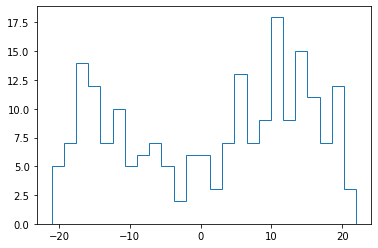

In [134]:
plt.hist(ypred, bins=25, histtype='step');

In [135]:
label=np.array(y_test_3)

c1_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==0.]
c2_pred = [ ypred[k] for k in range(len(ypred)) if label[k]==1.]

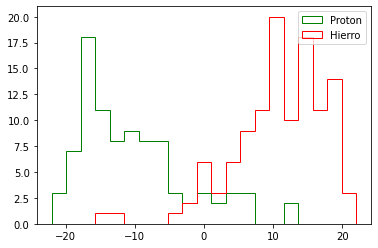

In [142]:
bins = np.linspace(-22, 22, 22)
plt.hist(c1_pred, bins, histtype='step', color='g', label="Proton");
plt.hist(c2_pred, bins, histtype='step', color='r', label="Hierro");
plt.legend()

## Conclusiones finales

Después de este recorrido por modelos de clasificación simple como la regresión logística y 
los *support vector clasifiers* hasta los modelos de ensamble como el *random forest* y el *voting* se encontró que el rendimiento en casi todos fue superior a 90%. Así mismo, se observo que el rendimiento en el conjunto de test sigue el mismo comportamiento.

Respecto a la validación se usó el *F1 score* y la *AUC-ROC* los cuales buscan obtener mediciones del *performance* que aseguren que los valores obtenido vía el *accuracy* o la matriz de confusión son acordes a la realidad y no están influenciados por un sobreajuste sobre los datos.

Finalmente, se puede destacar el papel del preanálisis en busca de mejorar el *performance*  mediante la búsqueda de nuevos *features* o una mejor estratificación de los conjuntos de datos. Esto permitio crear un conjunto
de datos con menos features lo cual simplifica el problema y evita usar aquellos que no tienen influencia en 
la clasificación.
